<a href="https://colab.research.google.com/github/chabelicastano/cap4770-spring23/blob/main/Labs/ChabeliCastano_deepLearningNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Apr 20 22:39:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Deep Learning for Natural Language Processing

Natural Language Processing (NLP) covers machine learning techniques dealing with text and includes

* classification
  * sentiment analyis (is this tweet a Pro-Biden or Anti-Biden one)
  * stylometrics (was this typed suicide note really from the deceased or did the murderer write it [1](https://www.rosette.com/case-studies/alias/), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3107011/)
  * general classification (out of 40 topics, which is this article about)
* question answering (building systems that can answer questions -- *What is the best treatment for hemangiosarcoma in dogs?*)
* machine translation
* speech recognition

among many others. Deep Learning has led to tremendous improvements in all these areas of NLP. 

In this notebook, we are going to examine classification systems for textual information.





## Analyzing and Classifying Text



<img src="https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/tiles.jpg" width="500"/>

So far we have been dealing with **structured data**. Structured data is ... well ... structured. This means that an instance of our data has nice attributes that can be represented in a DataFrame or a table:

make | mpg | cylinders | HP | 0-60 |
---- | :---: | :---: | :---: | :---: |
Fiat | 38 | 4 | 157   | 6.9 
Ford F150 | 19 | 6 | 386 | 6.3 
Mazda 3 | 37 | 4 | 155 |  7.5 
Ford Escape | 27 | 4 | 245 | 7.1 
Kia Soul | 31 | 4 | 164 | 8.5 

The majority of data in the world is **unstructured**. Take text for example. Suppose I have a corpus of twitter posts from former president Donald Trump and the Dalai Lama and my goal is to create a classifier that takes a tweet and tells me if it was produced by Trump or the Dalai Lama:

*The purpose of education is to build a happier society, we need a more holistic approach that promotes the practice of love and compassion.*

*How low has President Obama gone to tapp my phones during the very sacred election*

We might consider  the columns of a table to be things like *first word of the tweet*, *second word of the tweet* and so on:


id | word 1 | word 2 | word 3 | word 4 |word 5 |word 6 | ... |
---- | :---: | :---: | :---: | :---: | :---: |:---: |:---: |
1 | The | purpose | of   | education |is | to | ...
2 | How | low | has |President | Obama | gone | ...

So we would be counting how many times the word *President* occurred as the fourth word of a tweet. **But that would be the wrong way to go**. First, the deep learning models we have developed so far require input of a specific length. For example, we resized our dog and cat images to a uniform 150x150 and because each image was a uniform size we could specify the input shape of our network to be ....

```
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
```

But what should the input length be for tweets? Sometimes there are short, one-word, tweets like *nice*. The average length of a tweet is 30 characters so something like the six word *Today, Toaster is 10 years old.*  And the limit of course is 280 characters so...

> Like anything else, life has a beginning and in due course must end. In between those two events the important goal should be to live meaningfully, not to create trouble for others. If we can do that, when the end comes, we can go feeling at peace.

That's 47 words so maybe we can limit our input to 50 words and for shorter tweets we can pad them with blank words.  But there is another possibility ...

### Bag of Words (bow)

A more common way to represent text is to treat the text as an unordered set of words, which is called the **bag of words** approach. 


<img src="https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/BagofWords.jpg" width="350"/>

With the bag of words approach we count word occurrences and the features (what we might think of as columns) are the unique words. For example, we have a collection of Trump and Dalai Lama tweets and indicate whether the word occurred in the tweet or not. So we might get something like:

id | a | the | compassion | love |sad |fake | rigged | ... |
---- | :---: | :---: | :---: | :---: | :---: |:---: |:---: | :---:
Trump_1 | 1 | 0 | 0   | 0 |1 | 1 | 1 |...
Trump_2 | 1 | 1 | 0   | 0 | 0 | 1 | 1 |...
DalaiLama_1 | 1 | 1 | 1 |1 | 0 | 0 | 0 | ...

So, for example, in DalaiLama_1, in the text there was

* an occurrence of *a*
* an occurrence of *the*
* an occurrence of *compassion*
* an occurrence of *love*

We don't know what order the words occurred in, we just know what words occurred in the tweet. This is the bag-of-words method. 

Instead of short text snippets like tweets, let's say we are analyzing speeches of Trump and the Dalai Lama. Maybe then we will count how many times they used each word. So something like:

id | a | the | compassion | love |sad |fake | rigged | ... |
---- | :---: | :---: | :---: | :---: | :---: |:---: |:---: | :---:
Trump_1 | 52 | 25 | 0   | 0 |21 | 82 | 19 |...
Trump_2 | 30 | 35 | 0   | 0 | 5 | 20 | 31 |...
DalaiLama_1 | 60 | 271 | 27 |63 | 12 | 0 | 0 | ...

Of course we are still faced with how many columns to make, representing the vocabulary size. We could limit it to the 10,000 most common words, for example.

Once we have the text in this format we can use the standard deep learning classification techniques we used before.


Converting **unstructured** text to something **structured** is a multistep process. Let's learn the bits before putting it together. And we will start with the last step first-- creating the bag of words.

### Import Keras ...



In [3]:
import keras
keras.__version__

'2.12.0'

### Some sample data

In [4]:
trump1 = "How low has President Obama gone to tapp my phones during the very sacred election process. This is Nixon/Watergate. Obama bad (or sick) guy! Sad"
trump2 = "Our wonderful new Healthcare Bill is now out for review and negotiation. ObamaCare is a complete and total disaster - is imploding fast! Sad"
trump3 = "Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!"
trump4 = "Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks! Sad"
dalaiLama1 = "The purpose of education is to build a happier society, we need a more holistic approach that promotes the practice of love and compassion."
dalaiLama2 = "Be a kind and compassionate person. This is the inner beauty that is a key factor to making a better world."
dalaiLama3 = "If our goal is a happier, more peaceful world in the future, only education will bring change."
dalaiLama4 = "Love and compassion are important, because they strengthen us. This is a source of hope"
tinyCorpus = [trump1, trump2, trump3, trump4, dalaiLama1, dalaiLama2, dalaiLama3, dalaiLama4]
tinyCorpus

['How low has President Obama gone to tapp my phones during the very sacred election process. This is Nixon/Watergate. Obama bad (or sick) guy! Sad',
 'Our wonderful new Healthcare Bill is now out for review and negotiation. ObamaCare is a complete and total disaster - is imploding fast! Sad',
 "Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!",
 'Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks! Sad',
 'The purpose of education is to build a happier society, we need a more holistic approach that promotes the practice of love and compassion.',
 'Be a kind and compassionate person. This is the inner beauty that is a key factor to making a better world.',
 'If our goal is a happier, more peaceful world in the future, only education will bring change.',
 'Love and compassion are important, because they strengthe

### Create the bag of words

In [5]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=200)
tokenizer.fit_on_texts(tinyCorpus)

# Directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(tinyCorpus, mode='binary')
# let's look at an example of an encoding ...
print(one_hot_results[0])


# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

[0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Found 117 unique tokens.


That was pretty easy. And now we have the texts in a form we can use for deep learning.

Instead of the binary choice (a 1 if the word is present and a 0 if not) -- `mode='binary'` we can count how many occurrences of each word there were in the text by using `mode='count'`:


In [6]:
one_hot_results = tokenizer.texts_to_matrix(tinyCorpus, mode='count')
# let's look at an example of an encoding ...
print(one_hot_results[1])

[0. 0. 3. 2. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


So in the first tweet:

> 'Our wonderful new Healthcare Bill is now out for review and negotiation. ObamaCare is a complete and total disaster - is imploding fast! Sad',

There were 3 occurrences of the word *is*, 2 of *and*, and so on as indicated in the first row above.

How do we know what columns are associated with which words? We can use the word_index.



In [7]:
# tokenizer.word_index is a python dictionary containing the word as a key and the column as its value
[(k, v) for k, v in sorted(tokenizer.word_index.items(), key=lambda item: item[1])]

[('the', 1),
 ('is', 2),
 ('and', 3),
 ('a', 4),
 ('to', 5),
 ('this', 6),
 ('sad', 7),
 ('that', 8),
 ('in', 9),
 ('of', 10),
 ('obama', 11),
 ('election', 12),
 ('our', 13),
 ('out', 14),
 ('fake', 15),
 ('news', 16),
 ('big', 17),
 ('we', 18),
 ('are', 19),
 ('getting', 20),
 ('by', 21),
 ('education', 22),
 ('happier', 23),
 ('more', 24),
 ('love', 25),
 ('compassion', 26),
 ('world', 27),
 ('how', 28),
 ('low', 29),
 ('has', 30),
 ('president', 31),
 ('gone', 32),
 ('tapp', 33),
 ('my', 34),
 ('phones', 35),
 ('during', 36),
 ('very', 37),
 ('sacred', 38),
 ('process', 39),
 ('nixon', 40),
 ('watergate', 41),
 ('bad', 42),
 ('or', 43),
 ('sick', 44),
 ('guy', 45),
 ('wonderful', 46),
 ('new', 47),
 ('healthcare', 48),
 ('bill', 49),
 ('now', 50),
 ('for', 51),
 ('review', 52),
 ('negotiation', 53),
 ('obamacare', 54),
 ('complete', 55),
 ('total', 56),
 ('disaster', 57),
 ('imploding', 58),
 ('fast', 59),
 ("don't", 60),
 ('let', 61),
 ('tell', 62),
 ('you', 63),
 ('there', 64),
 

So, *the, is, and, a, to* are the words represented by the first five columns.


# TF-IDF representation

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/bigTFIDF.png)
So far we looked at 

* a binary bag-of-words (whether or not the word was present in the text).
* a raw count bag-of-words (counting how many occurrences of each word)

There are several other approaches
We could represent a document as a bag of words and their probabilities (`mode="freq"`). For example, in *Tom Sawyer* 4.6% of the words are *the* and 0.95% are *Tom*. But the word *the* probably occurs in most novels with that frequency. So in some sense the word *the* is uninteresting. On the other hand *Tom* probably occurs much more frequently in *Tom Sawyer* than it does in *Moby Dick* and, in that way, it is a more interesting word. One way to discount words that occur evenly throughout our document collection is to use TF-IDF.  

* TF: Term Frequency - each word uprated by how often the word occurs in the document.
* IDF Inverse Document Frequency - how often the word appears in the entire corpus



> TF-IDF was first proposed by Karen Sparck Jones as a heuristic--not having any theoretical foundation. Researchers since then have tried to justify this metric by relating it to probablistic theories and information theories. But these attempts have been problematic. Nevertheless, as we will see, this heuristic works quite well. 

The formula is

### $$ tfidf(t, d) = tf(t,d) \times idf(t) $$

where *t* is the term (the word) and *d* is the document.

To explain this I will use some made up data--the word counts of 5 emails (and for the sake of later computations let's assume that each email is 100 words long):

id | the | sad | compassion |  
----: | :---: | :---: | :---:
1 | 3 | 0 | 1 
2 | 3 | 0 | 0 
3 | 4 | 0 | 0 
4 | 3 | 2 | 0 
5 | 3 | 0 | 2


The intuition is this. Even though the word *the* occurs frequently in each email, it is unlikely to help us classify email because it occurs in **every** email. The words *sad* and *compassion* are more interesting as they don't occur uniformly in our collection. 

#### TF

The TF part of TF-IDF refers to how often the word occurs in the document. There are a number of ways to define TF. The simplist is to use the raw count.  So for example, the TF of *the* in document 1 is 3 (the word *the* occurred 3 times in document 1). One problem with this approach is that the raw count is influenced by the length of the document. So if you in your 1,000 word essay on Tom Sachs use 50 occurrences of *the* and Jane in her 90,000 word Zen van life mystery novel use 4,5000 occurrences of *the*, it doesn't mean that Jane is a bigger fan of *the* than you are. Even though there is that disparity in the raw counts it is not a characteristic that will help us distinguish texts about Zen from those about Tom Sachs.  In both the 1,000 word essay and the 90,000 word book about 5% of the words are *the*. A popular measure of TF is to divide the number of occurrences of a word by the total words in the document. So the TF of the word *the* in both your 1,000 word essay and my novel would be .05




#### IDF

IDF is defined as:

### $$ idf(t)=\log\frac{1+n_d}{1+df(d,t)}+ 1 $$

$n_d$ is the total number of documents and $df(d,t)$ is how many documents the term *t* occurred in. 

So:

### $$ idf(the)=\log\frac{1+5}{1+5}+ 1 =  1.5 $$

### $$ idf(compassion)=\log\frac{1+5}{1+2}+ 1 = \log{2} + 1 =  2 $$

So, *the* in document 1 has a tf-idf of $.03 \times 1.5 = 0.045$ and *compassion* has a tf-idf of $.01 \times \ 2 = 0.02$

This is a fairly important concept to understand. I was asked about tf-idf in my oral exam to become a certified instructor at the Deep Learning Institute and fortunately I knew about it. 

It is also important to know that while it works well as a heuristic and has been around since the 70s, there really is no theoretical foundation to it. 

With all that as background, it is easy to convert a document collection into an array of TFIDF values:

In [8]:
one_hot_results = tokenizer.texts_to_matrix(tinyCorpus, mode='tfidf')
# let's look at an example of an encoding ...
print(one_hot_results[1])

[0.         0.         1.33469384 1.29041528 0.84729786 0.
 0.         1.09861229 0.         0.         0.         0.
 0.         1.29928298 1.29928298 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.60943791 1.60943791
 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791
 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

Again, once we have this representation we can use the deep learning methods we already used.


## An initial example - IMDB

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/imdb.png)

The Internet Movie DataBase consists of 50,000 movie reviews and contains an equal number of positive and negative reviews. The task of identifying the affect of a text (whether it is postive or negative, or how strongly someone feels about the topic) is called **sentiment analysis**. 

### Load the data

In [9]:
!wget http://zacharski.org/files/courses/cs419/imdb.zip
!unzip imdb.zip

--2023-04-20 22:40:13--  http://zacharski.org/files/courses/cs419/imdb.zip
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26559010 (25M) [application/zip]
Saving to: ‘imdb.zip’

imdb.zip            100%[===================>]  25.33M  6.99MB/s    in 3.6s    

2023-04-20 22:40:18 (6.99 MB/s) - ‘imdb.zip’ saved [26559010/26559010]

Archive:  imdb.zip
  inflating: imdb.csv                


In [10]:
!ls -l

total 90608
-rw-r--r-- 1 root root 66212309 Oct 31  2020 imdb.csv
-rw-r--r-- 1 root root 26559010 Oct 31  2020 imdb.zip
drwxr-xr-x 1 root root     4096 Apr 19 13:37 sample_data


The zip file only contained one file so we could have read it directly.  Since we already unzipped it let's use the unzipped version.

In [11]:
import pandas as pd
data = pd.read_csv('imdb.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Now let's separate the texts from the labels. Also note that the labels are the strings *positive* and *negative* so let's convert those to 1 and 0.

In [12]:
data_text = data.review
data_label =data.sentiment
data_label =  data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
data_label 

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

### TFIDF
Now we are going to convert the text represented as strings to a tfidf representation. 

Let's use the 5,000 most common words in the documents (`Tokenizer(num_words=5000)`)

This will take a bit of time!

In [13]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_text)

# Directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(data_text, mode='tfidf')
# let's look at an example of an encoding ...
print(one_hot_results[0])

[0.         2.63159248 1.98374445 ... 0.         0.         0.        ]


###  Divide into training and test sets

In [14]:
from sklearn.model_selection import train_test_split
imdb_train_text, imdb_test_text, imdb_train_labels, imdb_test_labels = train_test_split(one_hot_results, data_label, test_size = 0.2, random_state=42)
imdb_test_labels


33553    1
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Name: sentiment, Length: 10000, dtype: int64

### Build a deep learning model
Let's go with a basic, no frills, model:

In [15]:
import keras
keras.__version__

'2.12.0'

In our tokenizer we specified a vocabulary size of 5,000 words, so that is our `input_shape`. We are trying to predict a binary 1,0 classification so we need 

```
network.add(layers.Dense(1, activation='sigmoid'))
```
at the very end of our network. 

We would like a network with

1. a dense layer with 512 nodes and input shape (5000,)
2. a dense layer of 256
3. A dense layer of 128
4. A dense layer (the output layer) of 1 with the sigmoid activation function.


In [16]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(5000,)))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

Again, we are predicting a binary 1,0 classification (was it a positive review or not) so we will use `binary_crossentropy` as our loss function

In [17]:
from keras import optimizers
network.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [18]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2560512   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,724,865
Trainable params: 2,724,865
Non-trainable params: 0
_________________________________________________________________


### fitting to the data
Now it is time to fit the network to the data. Let's use 20% of the data for validation and run for 30 epochs.

In [19]:
history = network.fit(
      imdb_train_text, imdb_train_labels,
      steps_per_epoch=100,
      epochs=30,
      validation_split=0.2,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 5s 13ms/step - loss: 0.4287 - accuracy: 0.8172 - val_loss: 0.3065 - val_accuracy: 0.8849
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2255 - accuracy: 0.9173 - val_loss: 0.2847 - val_accuracy: 0.8903
Epoch 3/30
100/100 [==============================] - 1s 8ms/step - loss: 0.1549 - accuracy: 0.9462 - val_loss: 0.3007 - val_accuracy: 0.8885
Epoch 4/30
100/100 [==============================] - 1s 8ms/step - loss: 0.1054 - accuracy: 0.9667 - val_loss: 0.3288 - val_accuracy: 0.8891
Epoch 5/30
100/100 [==============================] - 1s 8ms/step - loss: 0.0666 - accuracy: 0.9808 - val_loss: 0.3773 - val_accuracy: 0.8840
Epoch 6/30
100/100 [==============================] - 1s 9ms/step - loss: 0.0375 - accuracy: 0.9906 - val_loss: 0.4409 - val_accuracy: 0.8820
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0181 - accuracy: 0.9957 - val_loss: 0.5292 - val_accuracy: 0.8820
Epoc

### Our accuracy and loss
Let's plot out both the training and validation accuracy and loss.

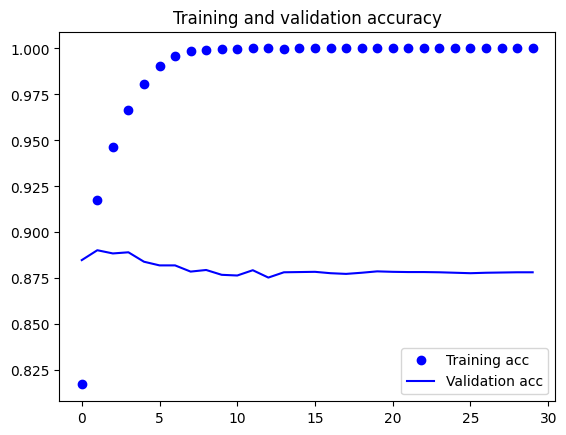

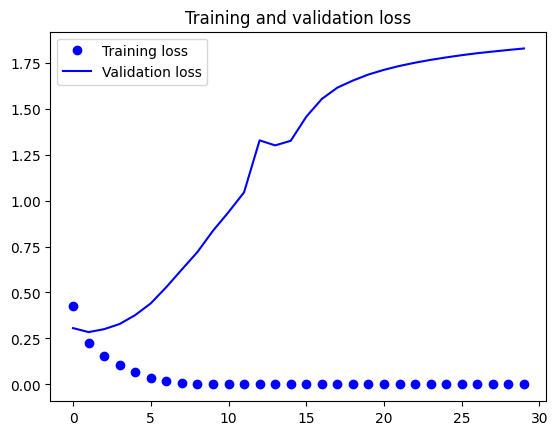

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

What is your interpretation of the plots?

.

.

.


Okay, that definitely looks like overfitting. We will examine ways of ameliorating overfitting shortly.  

Let's see how our network performs on the test data

In [21]:
scoreSeg = network.evaluate(imdb_test_text, imdb_test_labels)
print("Accuracy: ", scoreSeg[1])

313/313 [==============================] - 1s 2ms/step - loss: 1.7545 - accuracy: 0.8754
Accuracy:  0.8754000067710876


Not bad for our first attempt at text classification!!!

![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/torchdivide.png)


# <font color='#EE4C2C'>Climate Change ...</font> 



![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/factfake.jpeg)

On Twitter there are people who deny climate change:

> I don't know about you guys, but I think climate change is -- as Lord Monckton said -- bullsh*t

and people who believe it is real:

> Millennials, and Gen z, and all these folks that come after us, are looking up and we’re like ‘the world will end in 12 years if we don’t address climate change, and your biggest issue is how are we gonna pay for it?

We are going to investigate the sentiment of tweets from the Twitter Climate Change Sentiment Dataset compiled by Edward Qian. The dataset consists of 43,943 tweets. Instead of a binary label (a positive sentiment on climate change or a negative, there are four possible labels:

Label | Description
:--- | :---- 
News | the tweet links to factual news about climate change
Pro | the tweet supports the belief of man-made climate change
Neutral |  the tweet neither supports nor refutes the belief of man-made climate change
Anti | the tweet does not believe in man-made climate change


![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>1. Load the data.</font> 

The file is 

https://raw.githubusercontent.com/zacharski/ml-class/master/data/climateSentiment.csv.zip

You will need:

* to load the file
* convert the text of the tweet to a tf-idf representation. We will start with using the 5,000 most common words
* convert the labels
* divide into training and testing.

In [22]:
!wget https://raw.githubusercontent.com/zacharski/ml-class/master/data/climateSentiment.csv.zip

--2023-04-20 22:53:44--  https://raw.githubusercontent.com/zacharski/ml-class/master/data/climateSentiment.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589663 (2.5M) [application/zip]
Saving to: ‘climateSentiment.csv.zip’

climateSentiment.cs 100%[===================>]   2.47M  --.-KB/s    in 0.01s   

2023-04-20 22:53:45 (258 MB/s) - ‘climateSentiment.csv.zip’ saved [2589663/2589663]



In [23]:
!unzip climateSentiment.csv.zip

Archive:  climateSentiment.csv.zip
  inflating: climate.csv             


In [24]:
cc_tweets = pd.read_csv('climate.csv')
cc_tweets

,sentiment,message,tweetid
0,Anti,@tiniebeany climate change is an interesting h...,792927353886371840
1,Pro,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,Pro,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,Pro,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,News,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,Pro,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,Pro,What will your respective parties do to preven...,791316857403936768
43940,News,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,Neutral,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


In [25]:
# I'm converting the labels because the instructions said so, but I think we can also leave them as strings 
# and use "categorical_crossentropy"
custom_mapping = {'News': 0, 'Pro': 1, 'Neutral': 2, 'Anti': 3}
# change the value on the df
cc_tweets['sentiment'] = cc_tweets['sentiment'].map(custom_mapping)
cc_tweets

,sentiment,message,tweetid
0,3,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,0,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,1,What will your respective parties do to preven...,791316857403936768
43940,0,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,2,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


In [26]:
# labels
cc_labels = cc_tweets['sentiment']
# features
cc_text = cc_tweets.message

In [ ]:
cc_text

In [30]:
# tokenization
cc_tokenizer = Tokenizer(num_words=5000)
cc_tokenizer.fit_on_texts(cc_text)

#tfidf matrix
ohe_matrix = cc_tokenizer.texts_to_matrix(cc_text, mode='tfidf')

ohe_matrix[0]

array([0.        , 0.83715075, 0.85454543, ..., 0.        , 0.        ,
       0.        ])

In [31]:
#training and testing
cc_train_text, cc_test_text, cc_train_labels, cc_test_labels = train_test_split(ohe_matrix, cc_labels, test_size=0.2, random_state=42)
cc_test_labels

34461    2
20916    0
14218    1
30674    2
32400    1
        ..
33649    1
5523     1
25031    1
5638     1
17989    0
Name: sentiment, Length: 8789, dtype: int64

![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>2. Create a deep learning densely connected network.</font> 

You can decide how many layers and how many nodes per layer. Keep in mind that for the imdb task the last layer was:

```
network.add(layers.Dense(1, activation='sigmoid'))
```

The `1` was selected because we only had a binary choice (positive or negative). `sigmoid` was also selected because we had a binary choice.  This will not be the same for this task. In the imdb example, we used the binary_crossentropy loss function because, again, we only had a binary choice.

Create the network, compile it, and fit it to the data. 

In [38]:
# network
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(5000, )))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [41]:
# compile
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# fit
cc_history = model.fit(cc_train_text, cc_train_labels,
                       steps_per_epoch = 100,
                       epochs = 30,
                       validation_split=0.2,
                       validation_steps=50)

![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>2. Plot the accuracy and loss for both the training and validation sets.</font> 

Also, state in a few sentences what you see in the plots.

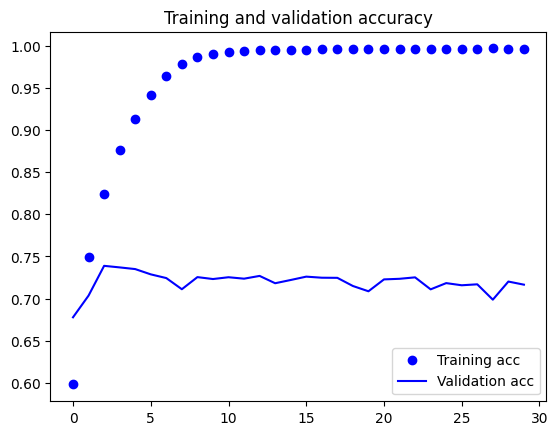

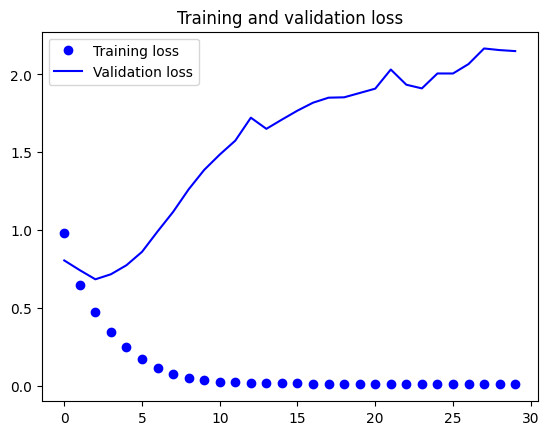

In [43]:
acc = cc_history.history['accuracy']
val_acc = cc_history.history['val_accuracy']
loss = cc_history.history['loss']
val_loss = cc_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model is clearly overfitting

![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>4. Accuracy on the test data</font> 

What is the accuracy on the test data?

In [44]:
cc_scoreSeg = model.evaluate(cc_test_text, cc_test_labels)
print("Accuracy: ", cc_scoreSeg[1])

275/275 [==============================] - 1s 3ms/step - loss: 2.1811 - accuracy: 0.7171
Accuracy:  0.7171464562416077


The accuracy on test data is 72%, not so good

![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>5. Can you do better than the baseline accuracy? +5-10 xp</font> 
Can you create a network that has better accuracy than that shown in #4 above?

You can change:

* the number of layers, 
* the number of nodes in each layer
* change the `num_words` used in the tokenizer
* add one or more dropout layers


In [74]:
from keras.backend import dropout
# Let's see
model2 = models.Sequential()
model2.add(layers.Dense(512, activation='relu', input_shape=(5000, )))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(4, activation='softmax'))

In [75]:
# compile
model2.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [76]:
# fit
cc_history2 = model2.fit(cc_train_text, cc_train_labels,
                       steps_per_epoch = 30,
                       epochs = 100,
                       validation_split=0.2,
                       validation_steps=50)

Epoch 1/100
30/30 [==============================] - 2s 48ms/step - loss: 1.1564 - accuracy: 0.5145 - val_loss: 1.0323 - val_accuracy: 0.5523
Epoch 2/100
30/30 [==============================] - 1s 24ms/step - loss: 0.9534 - accuracy: 0.6125 - val_loss: 0.8792 - val_accuracy: 0.6443
Epoch 3/100
30/30 [==============================] - 1s 21ms/step - loss: 0.7889 - accuracy: 0.6901 - val_loss: 0.7790 - val_accuracy: 0.6898
Epoch 4/100
30/30 [==============================] - 1s 27ms/step - loss: 0.6709 - accuracy: 0.7423 - val_loss: 0.7313 - val_accuracy: 0.7074
Epoch 5/100
30/30 [==============================] - 1s 22ms/step - loss: 0.5804 - accuracy: 0.7803 - val_loss: 0.7072 - val_accuracy: 0.7184
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.4999 - accuracy: 0.8160 - val_loss: 0.6889 - val_accuracy: 0.7274
Epoch 7/100
30/30 [==============================] - 1s 22ms/step - loss: 0.4336 - accuracy: 0.8461 - val_loss: 0.6882 - val_accuracy: 0.7265
Epoch 

In [77]:
scoreSeg3 = model2.evaluate(imdb_test_text, imdb_test_labels)
print("Accuracy: ", scoreSeg3[1])

313/313 [==============================] - 1s 2ms/step - loss: 35.4327 - accuracy: 0.4984
Accuracy:  0.4984000027179718


In [ ]:
# I tried several variations but couldn't get a better accuracy. No xp for me ):
# If I wasn't stdying for my finals, I could keep trying